<a href="https://colab.research.google.com/github/ebitnet65/QuDPi/blob/main/TCModel_ERB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tavis Cummings Model in QuTip/QuDPy

In [3]:
pip install qudpy

In [4]:
# allows better graphics
#%matplotlib notebook
import matplotlib.pyplot as plt

# importing required packages
from qutip import *  # for quantum dynamics
import numpy as np  # for numerical manipulations
from qudpy.Classes import *  # for nonlinear spectroscpy
import qudpy.plot_functions as pf  # for plotting nonlinear spectra
import ufss  # for double-sided diagram generation
import os

/usr/local/lib/python3.10/dist-packages/qutip/__init__.py:65: UserWarning: The new version of Cython, (>= 3.0.0) is not supported.
  warnings.warn(


In [ ]:
nSpins = 1
nPhoton = 2
Delta = 2.5
wc = 2.5
wRabi = 0.1

sp = (sigmax()+1j*sigmay())
sm = (sigmax()-1j*sigmay())
sz = sigmaz()
si = qeye(2)



Sp = []
Sm = []
Sz = []
Si = []


ident = qeye(nPhoton)
for n in range(nSpins ):
  op_list = []
  for m in range(nSpins ):
    op_list.append(si)

  op_list.append(qeye(nPhoton))

  op_list[n] = (sigmax()+1j*sigmay())
  Sp.append(tensor(op_list))
  op_list[n] = (sigmax()-1j*sigmay())
  Sm.append(tensor(op_list))
  op_list[n] = sz
  Sz.append(tensor(op_list))
  op_list[n] = si
  Si.append(tensor(op_list))

op_list = []
for m in range(nSpins ):
   op_list.append(si)
op_list.append(qeye(nPhoton))

op_list[nSpins] = destroy(nPhoton)
a = tensor(op_list)

Hcav = wc * a.dag()*a
Hspin = 0
Hint = 0
SzTot = 0
SmTot = 0
SpTot = 0
for n in range(nSpins):
  SzTot += Sz[n]
  SmTot += Sm[n]
  SpTot += Sm[n].dag()

Hspin = (Delta/2)*SzTot
Hint = (wRabi/np.sqrt(nSpins))*(a.dag()*SmTot + SpTot*a)

H = Hcav + Hspin + Hint + 0.5*Delta*nSpins


en,T = H.eigenstates()
print(en)

[0.  2.3 2.7 5. ]


now let's do this creating the spins as kroneker products

Now, let's try to use this model to do a quantum dynamics calculation

In [ ]:

# Setting up the required double sided diagrams for tests
# DiagramGenerator class, or DG for short
DG = ufss.DiagramGenerator
# initialize the module
R3rd = DG()  # DG takes a single key-word argument, which has the default value detection_type = 'polarization'
# DiagramAutomation needs to know the phase-matching/-cycling condition
R3rd.set_phase_discrimination([(0, 1), (1, 0), (1, 0)])  # setting phase-matching condition for rephasing diagrams R1,2,3
# Set the pulse durations for pulses 0,1,2 and the local oscillator
d0 = 2
d1 = 4
d2 = 4
dlo = 6
# Set the pulse intervals
t0 = np.array([-d0 / 2, d0 / 2])
t1 = np.array([-d1 / 2, d1 / 2])
t2 = np.array([-d2 / 2, d2 / 2])
tlo = np.array([-dlo / 2, dlo / 2])
all_pulse_intervals = [t0, t1, t2, tlo]

# These pulse intervals are given to DG by setting DG's efield_times attribute
R3rd.efield_times = all_pulse_intervals
time_ordered_diagrams_rephasing = R3rd.get_diagrams([0, 100, 200, 200]) # selecting pulse arrival times to ensure no pulses overlap.
[R3, R1, R2] = time_ordered_diagrams_rephasing
rephasing = [R1, R2, R3]
#print('the rephasing diagrams are R1, R2 and R3 ', R1, R2, R3)
#R3rd.display_diagrams(rephasing)

In [ ]:


gamma2 = 0.01
gamma1d = 0.01

en,T = H.eigenstates()

Hd = H.transform(T)


muOp = (a + a.dag())

A = (a + a.dag()).transform(T)
mud = muOp.transform(T)

# spin dephasing
cop1 = np.sqrt(gamma2)*SzTot
# Spin relaxations
cop3 = np.sqrt(gamma1d)*SmTot

# cavity relax
cop2 = 0.5* a

#define density matrix in eigenbasis
#--this is a bit wierd since you have to define the density matrix as a qutip Quantum Object
# that's in the same representation as the other operators you're using.  Sort of a pain in the rear..

# psi0 needs to be the ground-state of the system
min_pos = np.argmin(en)

psi0 = T[min_pos]

rho = psi0*psi0.dag()
sys2 = System(H=Hd,a=A,u=mud,c_ops=[cop1,cop2,cop3],rho=rho)

system initialized


total diagrams 1 , total interactions  3
('Bu', 0)
('Ku', 1)
('Bd', 2)
('Bu', 0)
('Ku', 1)
('Bd', 2)
('Bu', 0)
('Ku', 1)
('Bd', 2)


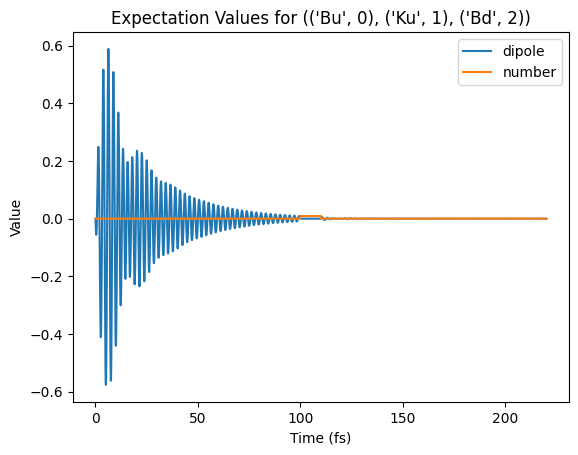

In [ ]:
states = sys2.diagram_donkey([0, 100, 110, 220], [R1], r=10)

In [ ]:
time_delays = [200, 5, 200]
scan_id = [0, 2]
response_list = []

for k in range(3):
    states, t1, t2, dipole = sys2.coherence2d(time_delays, rephasing[k], scan_id,r=5, parallel=True)
    response_list.append(np.imag(dipole))

First scan done, starting second scan. Remaining time = First Scan Time x number of steps in second scan/number of processors
second scan done
First scan done, starting second scan. Remaining time = First Scan Time x number of steps in second scan/number of processors
second scan done
First scan done, starting second scan. Remaining time = First Scan Time x number of steps in second scan/number of processors
second scan done


centering data around zero


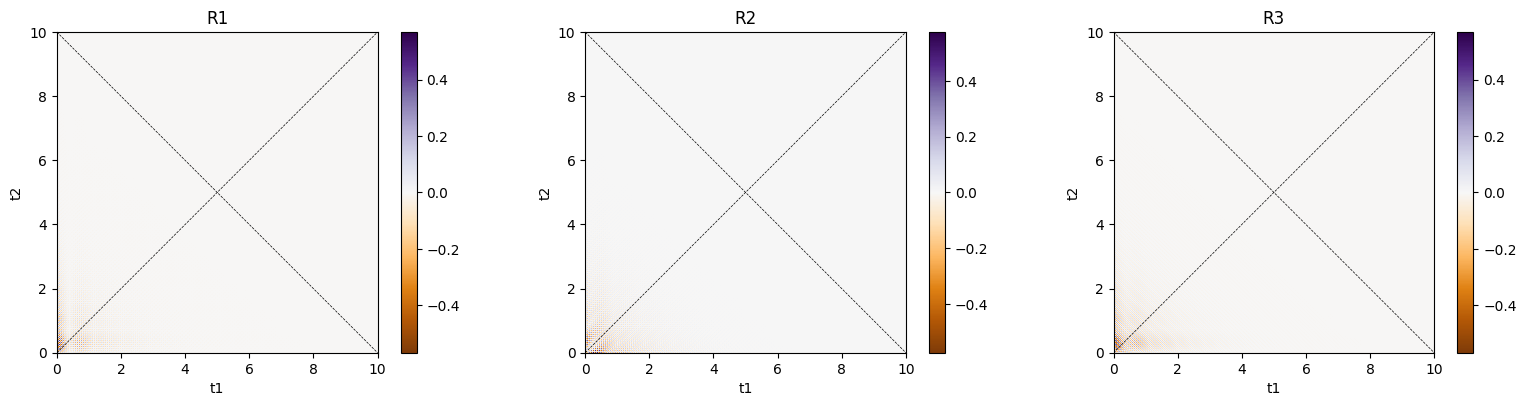

centering data around zero


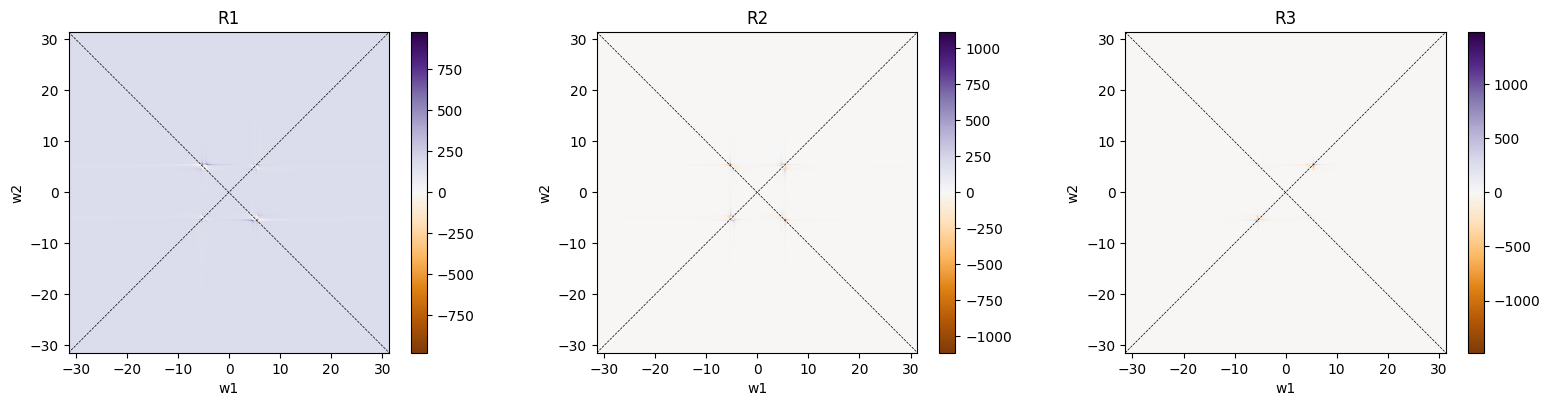

centering data around zero


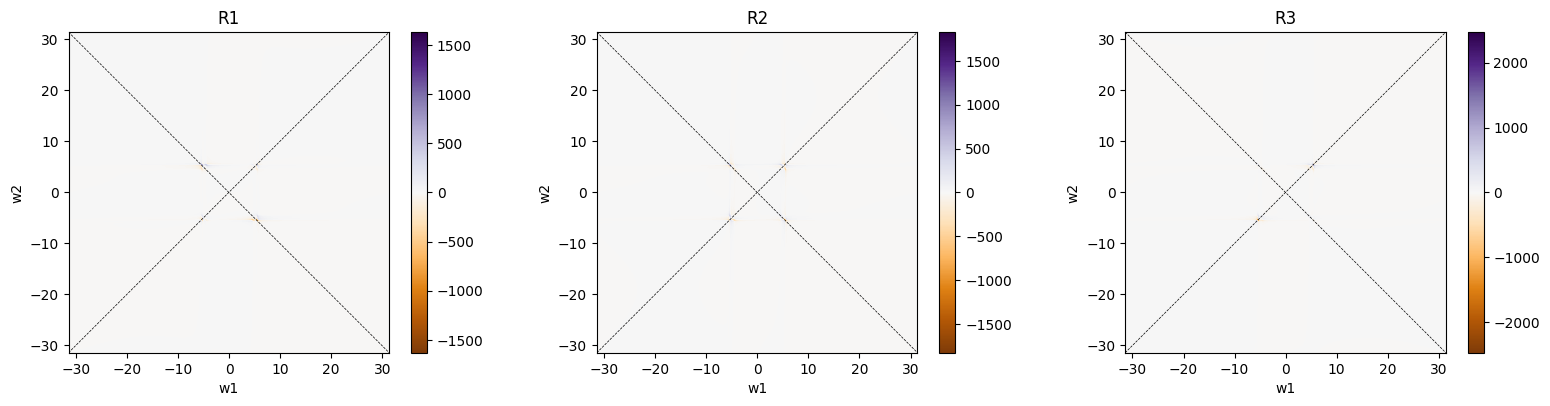

In [ ]:
spectra_list, extent, f1, f2 = sys2.spectra(response_list)
# Uncomment the lines below to plot the time domain dipole signal
pf.multiplot(response_list, [0, 10, 0, 10], ['t1', 't2'], ['R1', 'R2', 'R3'], 'linear')
pf.multiplot(np.real(spectra_list), extent, ['w1', 'w2'], ['R1', 'R2', 'R3'], 'linear')
pf.multiplot(np.imag(spectra_list), extent, ['w1', 'w2'], ['R1', 'R2', 'R3'], 'linear')

# (14-Nov) Two excitons + cavity model

In this example, we want to consider the case where you have 2 discrete excitonm states, coupled to a common cavity mode.  HTis is in effect a 2-spin Tavis Cummings model with the exception that the two excitons have different energies. Further, the tqwo excitons can interconvert via non-coherent relaxation introdiced via a Lindblad term.  The parameters should correspond to the data in the 2019 paper by Thouin et al.   We could include an d internal vibrational mode to the system at some point.



Import required packages

In [ ]:
pip install qudpy



In [ ]:
# allows better graphics
#%matplotlib notebook
import matplotlib.pyplot as plt

# importing required packages
from qutip import *  # for quantum dynamics
import numpy as np  # for numerical manipulations
from qudpy.Classes import *  # for nonlinear spectroscpy
import qudpy.plot_functions as pf  # for plotting nonlinear spectra
import ufss  # for double-sided diagram generation
import os


Set up the model

In [5]:
a = tensor(destroy(2),qeye(2),qeye(2))
xa  = tensor(qeye(2),destroy(2),qeye(2))
xb = tensor(qeye(2),qeye(2),destroy(2))

wc = 2.0
wA = 1.8
wB = 2.0
gA = 0.1
gB = 0.1
gamma = 0.1


H = wc*a.dag()*a + wA*xa.dag()*xa + wB*xb.dag()*xb + gA*(a.dag()*(xa+xb)+ a*(xa.dag()+xb.dag()))

# exciton relaxation
cop1 = np.sqrt(gamma)*xa.dag()*xb

# cavity relaxation
cop2 = np.sqrt(kappa)*a

# exciton dephasing
cop3 = np.sqrt(gammaA)*(xa.dag()*xa)
cop4 = np.sqrt(gammaB)*(xb.dag()*xb)

en,T = H.eigenstates()

print(en)

[0.         1.75188057 1.93111078 2.11700865 3.68299135 3.86888922
 4.04811943 5.8       ]


In [6]:

# Setting up the required double sided diagrams for tests
# DiagramGenerator class, or DG for short
DG = ufss.DiagramGenerator
# initialize the module
R3rd = DG()  # DG takes a single key-word argument, which has the default value detection_type = 'polarization'
# DiagramAutomation needs to know the phase-matching/-cycling condition
R3rd.set_phase_discrimination([(0, 1), (1, 0), (1, 0)])  # setting phase-matching condition for rephasing diagrams R1,2,3
# Set the pulse durations for pulses 0,1,2 and the local oscillator
d0 = 2
d1 = 4
d2 = 4
dlo = 6
# Set the pulse intervals
t0 = np.array([-d0 / 2, d0 / 2])
t1 = np.array([-d1 / 2, d1 / 2])
t2 = np.array([-d2 / 2, d2 / 2])
tlo = np.array([-dlo / 2, dlo / 2])
all_pulse_intervals = [t0, t1, t2, tlo]

# These pulse intervals are given to DG by setting DG's efield_times attribute
R3rd.efield_times = all_pulse_intervals
time_ordered_diagrams_rephasing = R3rd.get_diagrams([0, 100, 200, 200]) # selecting pulse arrival times to ensure no pulses overlap.
[R3, R1, R2] = time_ordered_diagrams_rephasing
rephasing = [R1, R2, R3]
#print('the rephasing diagrams are R1, R2 and R3 ', R1, R2, R3)
#R3rd.display_diagrams(rephasing)

In [7]:
en,T = H.eigenstates()

Hd = H.transform(T)


muOp = (a + a.dag())

A = (a + a.dag()).transform(T)
mud = muOp.transform(T)

# Lindblad operators in diagonal rep
cop1d = cop1.transform(T)
cop2d = cop2.transform(T)
cop3d = cop3.transform(T)
cop4d = cop4.transform(T)

cop_list = [cop1d,cop2d,cop3d,cop4d]


#define density matrix in eigenbasis
#--this is a bit wierd since you have to define the density matrix as a qutip Quantum Object
# that's in the same representation as the other operators you're using.  Sort of a pain in the rear..

# psi0 needs to be the ground-state of the system
min_pos = np.argmin(en)

psi0 = T[min_pos]

rho = psi0*psi0.dag()
sys2 = System(H=Hd,a=A,u=mud,c_ops=cop_list,rho=rho)

system initialized


total diagrams 1 , total interactions  3
('Bu', 0)
('Ku', 1)
('Bd', 2)
('Bu', 0)
('Ku', 1)
('Bd', 2)
('Bu', 0)
('Ku', 1)
('Bd', 2)


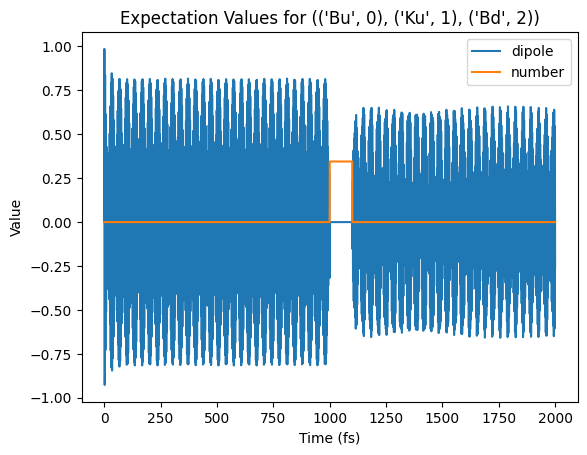

In [8]:
states = sys2.diagram_donkey([0, 1000, 1100, 2000], [R1], r=10)

In [ ]:
time_delays = [500, 5, 500]
scan_id = [0, 2]
response_list = []

for k in range(3):
    states, t1, t2, dipole = sys2.coherence2d(time_delays, rephasing[k], scan_id,r=5, parallel=True)
    response_list.append(np.imag(dipole))

First scan done, starting second scan. Remaining time = First Scan Time x number of steps in second scan/number of processors


In [ ]:
spectra_list, extent, f1, f2 = sys2.spectra(response_list)
# Uncomment the lines below to plot the time domain dipole signal
pf.multiplot(response_list, [0, 500, 0, 500], ['t1', 't3'], ['R1', 'R2', 'R3'], 'linear')
pf.multiplot(np.real(spectra_list), extent, ['w1', 'w3'], ['R1', 'R2', 'R3'], 'linear')
pf.multiplot(np.imag(spectra_list), extent, ['w1', 'w3'], ['R1', 'R2', 'R3'], 'linear')